### Transfer Learning
### Fine-tuning VGG16 on Cats & Dogs dataset
In this tutorial we will learn how to fine-tune a pre-trained network on a new dataset.
We will perform the following steps:
1. Load and normalizing the cats & dogs dataset
2. Load pre-trained VGG-16 
3. Remove top layers (fully connected layers)
4. Freeze the network
4. Add new layers (classifier)
5. Train the network
6. Test on test data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm.auto import tqdm

### Load Dataset usign torchvision image loader

In [0]:
data_dir = './drive/My Drive/A_05_Part_02_Dataset'
model_dir = './drive/My Drive/A_05_Part_02_Models'
mycase = 2*10+100
save_state_vgg16=0
save_state_resnet18=0

In [5]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

test_data_test = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

testloader_test = torch.utils.data.DataLoader(test_data_test, batch_size=1, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [7]:
print("Classes: ")
class_names = test_data.classes
print(class_names)

Classes: 
['covid', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


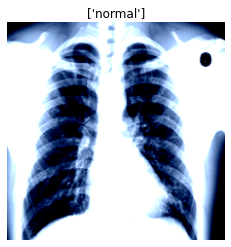

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(testloader))
show_databatch(inputs, classes)

### Load pre-trained VGG-16

In [0]:
#vgg-16 loaing and editing cell
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('\nVGG-16 loaded\n')
print('\nShow only classifier layer\n')
print(vgg16.classifier)
for param in vgg16.parameters():
    print(param.requires_grad)
    param.requires_grad=False
print('\nAll layers frozen\n')
old_layer=vgg16.classifier
in_size=old_layer[0].in_features
vgg16.classifier=nn.Sequential(
    nn.Linear( in_size, mycase, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(mycase,len(class_names), bias=True)
  )
print('\nNewly added layers below\n')
print(vgg16.classifier)
print('\nShow trainable state of entire vgg16\n')
for param in vgg16.parameters():
    print(param.requires_grad)
print('\nOnly Show trainable state of vgg16 classifier layer\n')
for param in vgg16.classifier.parameters():
    print(param.requires_grad)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Load pre-trained ResNet-18

In [0]:
#resnet-18 loading and editing cell
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
print('\nResnet loaded\n')
print('\nShow only fc layer\n')
print(resnet18.fc)
for param in resnet18.parameters():
    param.requires_grad=False
print('\nAll layers frozen\n')
old_layer=resnet18.fc
in_size=old_layer.in_features
resnet18.fc=nn.Sequential(
    nn.Linear( in_size, mycase, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(mycase,len(class_names), bias=True)
  )
print('\nNewly added layers below\n')
print(resnet18.fc)
print('\nShow trainable state of entire resnet\n')
for param in resnet18.parameters():
    print(param.requires_grad)
print('\nShow trainable strate of fc layer only\n')
for param in resnet18.fc.parameters():
    print(param.requires_grad)

### Removing Layer already done

### Freezing the layers already done

### Adding New Layer already done

i was here trying to setup vgg16 as well as resnet18 and both have been loaded and editied

#Load models, if saved already

#####vgg16

In [31]:
vgg16path = model_dir + '/vgg16/good_basic.pth'
print(vgg16path)

#torch.save(vgg16, vgg16path)
if(save_state_vgg16==0):
    vgg16 = models.vgg16(pretrained=False)
    vgg16 = torch.load(vgg16path)
    print('Loaded vgg16 model\n')
    vgg16.classifier[3] = nn.Linear( 120, len(test_data.classes), bias=True)
    print(vgg16)


./drive/My Drive/A_05_Part_02_Models/vgg16/good_basic.pth
Loaded vgg16 model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(in

#####resnet18

In [0]:
#resnet store and load
#print('stored resnet18 model\n')
#print(resnet18)
resnet18path = model_dir + '/resnet18/resnet18_01.pth'
print(resnet18path)

#torch.save(resnet18, resnet18path)
if(save_state_resnet18==0):
    resnet18 = models.resnet18(pretrained=False)
    resnet18 = torch.load(resnet18path)
    print('Loaded resnet18 model\n')
    print(resnet18)

### Loss fucntion and optimizer, VGG-16

In [0]:
Epochs_vgg = 1
focal_loss = torch.tensor([20,1,2])
criterion_vgg = nn.BCEWithLogitsLoss(pos_weight=focal_loss.to(device))
#criterion_vgg = nn.BCEWithLogitsLoss()
#i was here 02:24 01-05-2020
optimizer_vgg = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))
print(torch.cuda.get_device_capability(device))
#

Tesla P100-PCIE-16GB
(6, 0)


In [0]:
Epochs_vgg = 5

In [0]:
vgg16.to(device)

###Label processing functions

In [0]:
def label_mod(label_value, batch_num):
    #this is not a generic function
    new_label=torch.zeros(batch_num,3)
    for num in range(batch_num):
        if(label_value[num]==0):
            new_label[num,:] = torch.tensor([1,0,1])
        if(label_value[num]==1):
            new_label[num,:] = torch.tensor([0,1,0])
        if(label_value[num]==2):
            new_label[num,:] = torch.tensor([0,0,1])
    return new_label.to(device)

In [0]:
def label_round(label, n=1):
    #special round function
    if(n>1):
        for k in range(n):
            for ii in range(3):
                if(label[k,ii]>0.5):
                    label[k,ii] = 1
                else:
                    label[k,ii] = 0
    else:
        for ii in range(3):
            if(label[ii]>0.5):
                label[ii] = 1
            else:
                label[ii] = 0
    return label

In [0]:
def multilabel_accuracy(label1, label2,n_labels=3, batch_size=1):
    c0 = 0
    accuracy_value=0
    if(batch_size <1):
        batch_size=1
    if(batch_size > 1):
        for k in range(batch_size):
            c1 = 0
            for i in range(n_labels):
                if(label1[k,i]==label2[k,i]):
                    c1 = c1+1
            op1 = c1
            op2 = n_labels + n_labels -c1
            c0 = op1/op2
            accuracy_value += c0
    else:
        c1 = 0
        for i in range(n_labels):
            if(label1[i]==label2[i]):
                c1 = c1+1
        op1 = c1
        op2 = n_labels + n_labels -c1
        accuracy_value = op1/op2

    return accuracy_value/batch_size

### Training, VGG-16

In [36]:
#from tqdm.auto import tqdm
train_curve = np.append([],[])
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.train()
for epoch in range(Epochs_vgg):  # loop over the dataset multiple times
#for epoch in tqdm(range(Epochs)):  # loop over the dataset multiple times
    multi_accu = 0

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader.dataset)//trainloader.batch_size)
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer_vgg.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion_vgg(outputs, label_mod(labels,trainloader.batch_size))   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer_vgg.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        #multilabel accuracy
        multi_accu += multilabel_accuracy( 
            label_round(outputs,trainloader.batch_size).int(), 
            label_mod(labels, trainloader.batch_size).int(), 
            len(train_data.classes),
            trainloader.batch_size 
            )
        train_curve =np.append(train_curve, multi_accu)
        #pbar.set_description(
            #'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, i * len(inputs), len(trainloader.dataset),
                #100. * i / len(trainloader),
                #loss.data))
                #loss.data[0]))
        
    #torch.save(vgg16, vgg16path)
    #if(save_state_vgg16==0):
      #save_state_vgg16=1

print('Finished Training')
print('Multilabel Training accuracy = ',100*multi_accu*trainloader.batch_size/len(train_data.samples))


Finished Training
Multilabel Training accuracy =  83.48709677419355


### Testing, VGG-16

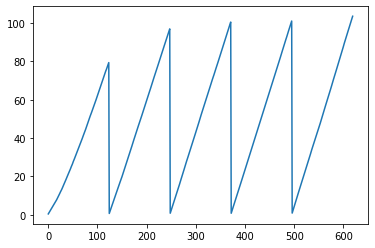

In [37]:
plt.plot(train_curve)
np.savetxt(model_dir + '/train_curve_2_01_all5.csv' ,train_curve,fmt='%2f',delimiter=',')

In [0]:
print(train_curve)

In [0]:
dataiter = iter(testloader)

In [0]:

images, labels = dataiter.next()
#show_databatch(images, label_mod(labels,testloader.batch_size))
print(label_mod(labels,testloader.batch_size))

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
print(outputs[0])
print(label_round(outputs[0]))
_, predicted = torch.max(outputs, 1)
#i was here, develop an accuracy calculating function 02:07 04-05-2020
print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

In [38]:
#Accuracy on validation set
correct = 0
total = 0
multi_accu_valid=0
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        multi_accu_valid+=multilabel_accuracy( 
            label_round(outputs.flatten(),testloader.batch_size).int(), 
            label_mod(labels, testloader.batch_size).flatten().int(), 
            len(test_data.classes),
            testloader.batch_size 
            )
print('multilabel accuracy = ',100*multi_accu_valid*testloader.batch_size/len(test_data.samples))
print('Accuracy of the network on the ',total,' validation set images: %d %%' % (
    100 * correct / total))


multilabel accuracy =  87.13375796178342
Accuracy of the network on the  628  validation set images: 85 %


In [0]:
print((multi_accu_valid/len(test_data.samples)))

0.7735668789808872


In [0]:
#Accuracy on test set
correct = 0
total = 0
count=0
val = np.zeros([629,3], dtype='int32')
with torch.no_grad():
    for data in tqdm(testloader_test):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        val[count,:] =  label_round(outputs.flatten(),testloader.batch_size).int().cpu().numpy() 
        print(val[count,:])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        count += 1

print('Accuracy of the network on the ',total,' test set images: %d %%' % (
    100 * correct / total))

In [0]:
np.savetxt(model_dir+'/vgg16/test_set_results.csv',val,fmt='%2f',delimiter=',')

In [0]:
#Accuracy on training set
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the ',total,' training set images: %d %%' % (
    100 * correct / total))

### Loss function and optimizer, ResNet-18
#all below needs variable name correction


In [0]:
Epochs_res = 10
criterion_res = nn.CrossEntropyLoss()
optimizer_res = optim.SGD(resnet18.parameters(), lr=0.000005, momentum=0.9)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))
print(torch.cuda.get_device_capability(device))
resnet18.to(device)

Tesla P100-PCIE-16GB
(6, 0)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training, ReNset-18

In [0]:
#from tqdm.auto import tqdm #already loaded

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
for epoch in range(Epochs_res):  # loop over the dataset multiple times
#for epoch in tqdm(range(Epochs)):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader.dataset)//trainloader.batch_size)
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer_res.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion_res(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer_res.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
                #loss.data[0]))
        
    torch.save(resnet18, resnet18path)
    if(save_state_resnet18==0):
      save_state_resnet18=1

print('Finished Training')

### Testing, ResNet-18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


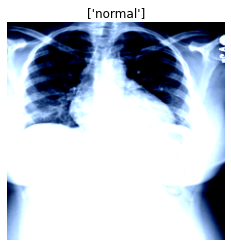

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal
Ground Truth:  normal


In [0]:
#Accuracy on validation set
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the ',total,' validation images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the  1500  validation images: 42 %


In [0]:
#Accuracy on test set
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader_test):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the ',total,' test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the  1500  test images: 43 %


In [0]:
#Accuracy on training set
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the ',total,' training set images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the  12000  training set images: 44 %


#Manual Save cells

In [0]:
pth01 = model_dir + '/vgg16/good_multilabel_vgg16_withfocalloss02.pth'
torch.save(vgg16,pth01)

In [0]:
pth01 = model_dir + '/resnet18/good.pth'
torch.save(resnet18,pth01)

#Manual Load cells

In [0]:
pth01 = model_dir + '/vgg16/good.pth'
vgg16 = models.vgg16(pretrained=False)
vgg16 = torch.load(pth01)

In [0]:
pth01 = model_dir + '/resnet18/asd.pth'
resnet18 = models.resnet18(pretrained=False)
resnet18 = torch.load(pth01)

In [21]:
asdfg=torch.cuda.get_device_properties(0)
print(asdfg.total_memory)

17071734784


In [0]:
print('Loading training data set to cuda device')
for data in tqdm(trainloader):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

print('Training data set succesfully loaded to cuda device')

Loading training data set to cuda device



Training data set succesfully loaded to cuda device


In [0]:
print('Loading validation data set to cuda device')
for data in tqdm(testloader):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

print('Validation data set succesfully loaded to cuda device')

Loading validation data set to cuda device



Validation data set succesfully loaded to cuda device


In [0]:
print('Loading train data set for intra comparision')
c0=0
c1=0
c2=0
dar =0 
for data in tqdm(testloader):
    c0 = c0+1
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    if(labels == 0):
        der=0
        c1 = torch.tensor([1, 0, 1])
    if(labels == 1):
        der=1
        c1 = torch.tensor([0, 1, 0])
    if(labels == 2):
        der=2
        c1 = torch.tensor([0, 0, 1])
    print('labels =\n',labels)
    print('got ', test_data.classes[der],' with c0 = ',c0)
    data. = c1.to(device)
    print('new labels =\n',labels)
    c2 = c2 +1
    if(c0%100==0):
        print('labels type and value = ',type(labels), labels)
        print('c0 = ',c0,'\nc1 = ',c1,'\nc2 = ',c2)
print('Train data set succesfully intra compared')
print('c0 = ',c0,'\nc1 = ',c1,'\nc2 = ',c2)

In [0]:
#print(label_mod(labels,50))
#print(len(train_data.samples))

6200
